## Summarising data across repeated runs of same workload 

In [3]:
import json
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITHOUT_ISTIO_WITH_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 5
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

#### Identifying most important functions by count

In [5]:
def get_runs():
    runs = []
    # for run_data in os.listdir(PARSED_OUTPUTS):
    for i in range(NUM_RUNS):
        with open(os.path.join(PARSED_OUTPUTS, f'{i}.json'), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [6]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]
    print(y[0])

    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

In [16]:
def get_pid_mapping(file):
    pid_mapping={}
    with open(file,'r') as f:
        for line in f.readlines():
            
            pid,*name= line.split()
            if(type(name)==list):
                name=' '.join(name)
            pid_mapping[pid]=name
            
    return pid_mapping

In [8]:
def get_function_counts_per_process(run, run_no, recurse=False):
    count = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    def get_counts(function, count, recurse,pid):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, {})
            count[func_name][pid] = count.get(func_name).get(pid,0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse,pid)
    for pid in run:
        # count[pid]={}
        for function in run[pid]:
            get_counts(function, count, recurse,pid)
    for function,data in count.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + count[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + count[function][pid]
    return process_count
        
def plot_stacked_counts(count, title=WORKLOAD, maxnum=20):
    processes= set()
    for data in count.values():
        for proc in data:
            if proc != 'total':
                processes.add(proc)
    processes= list(processes)
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x]['total'], reverse=True)[ :maxnum]
    yold=[0 for _ in range(len(x))]
    plt.figure(figsize=(10, 4))
    for proc in processes:
        y=[0 for _ in range(len(x))]
        for i in range(len(x)):
            y[i] = count[x[i]].get(proc,0)
        plt.bar(x,y,bottom=yold)
        yold = [yold[i] + y[i] for i in range (len(y))]
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.show()
    del x, y



In [9]:
runs = get_runs()

Removing noise from runs using baseline run

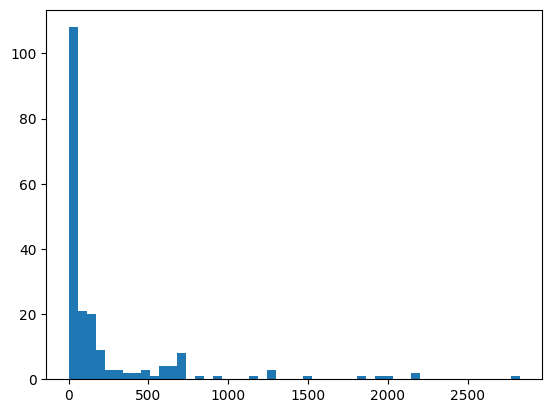

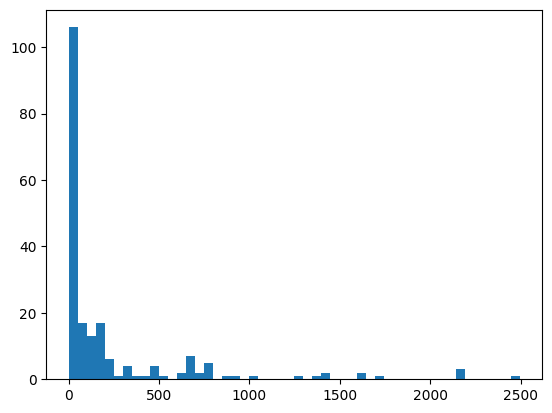

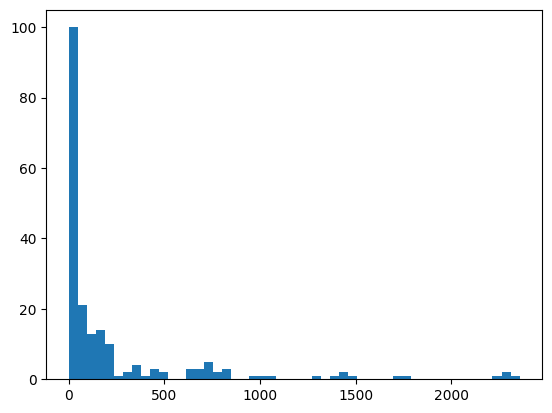

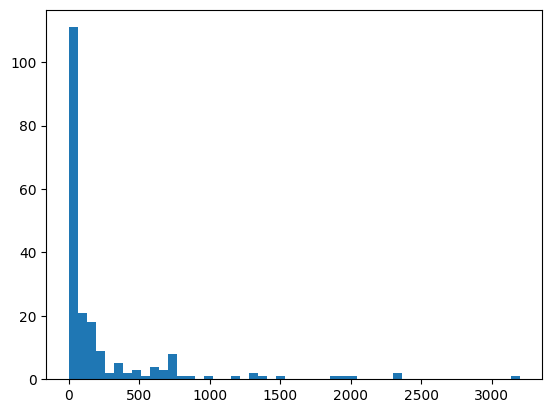

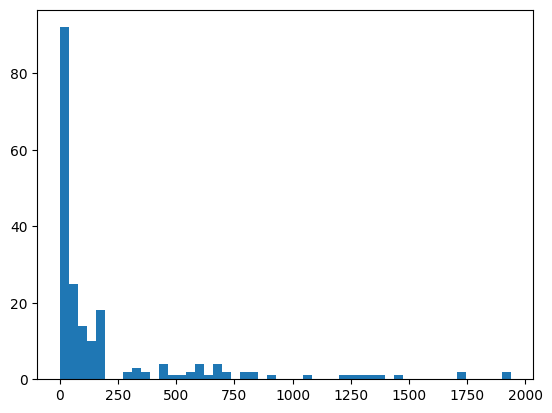

In [6]:
with open("pickles/baselines/WITHOUT_ISTIO_WITHOUT_WORKLOAD", "rb") as f:
    baseline = pickle.load(f)

# Observing distribution of "noisy" functions in workload enabled trace compared to empty trace
for i in range(NUM_RUNS):
    base_counts = {}
    count = get_function_counts(runs[i], recurse=True)
    for function in baseline:
        base_counts[function] = count.get(function, 0)
    plt.hist(base_counts.values(), bins=50)
    plt.show()
    

The common functions in the baseline run do not seem to be as common in the run with workload. Many functions have frequency of 0 i.e, they did not appear in the trace for runs with workload at all. Possible reasons could be 
* as CPU is idle during no-workload runs, the process is often switched out of memory which generates trace for many functions but these functions aren't as frequent when CPU is busy. This is corroborated by the fact that many kernel functions in the baseline trace are functions such related to sleeping and waking up threads, idle cpu behaviour, etc

<img src="images/ftrace_idle_common.png">


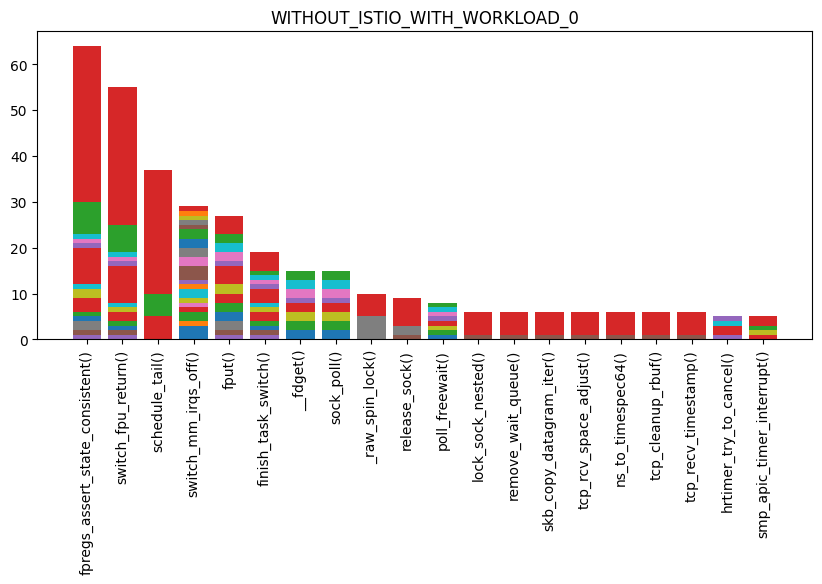

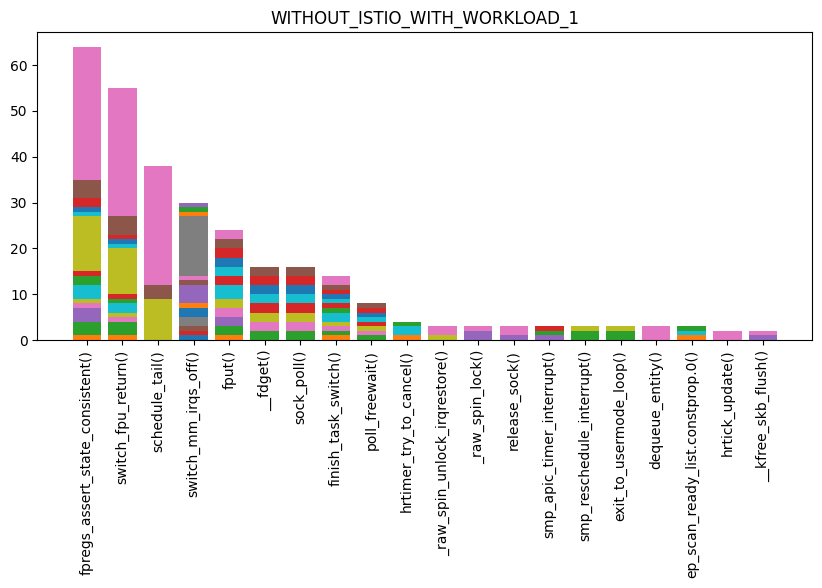

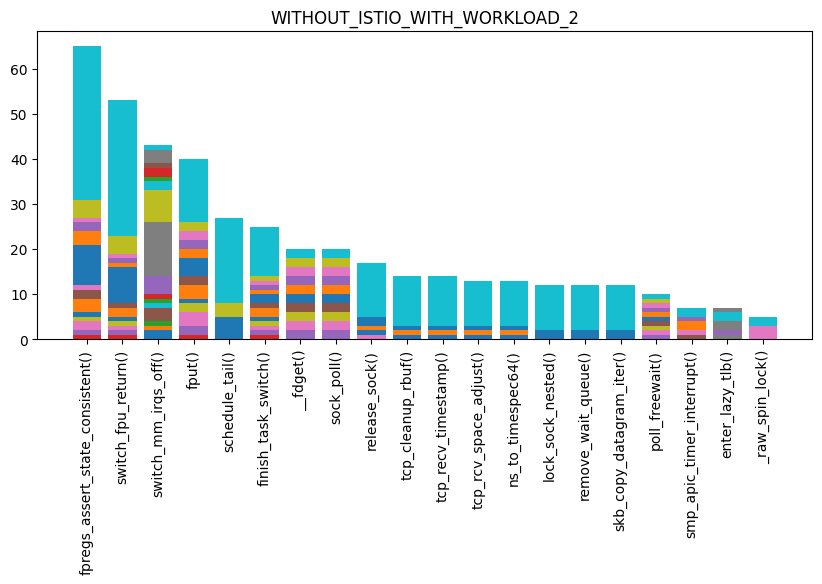

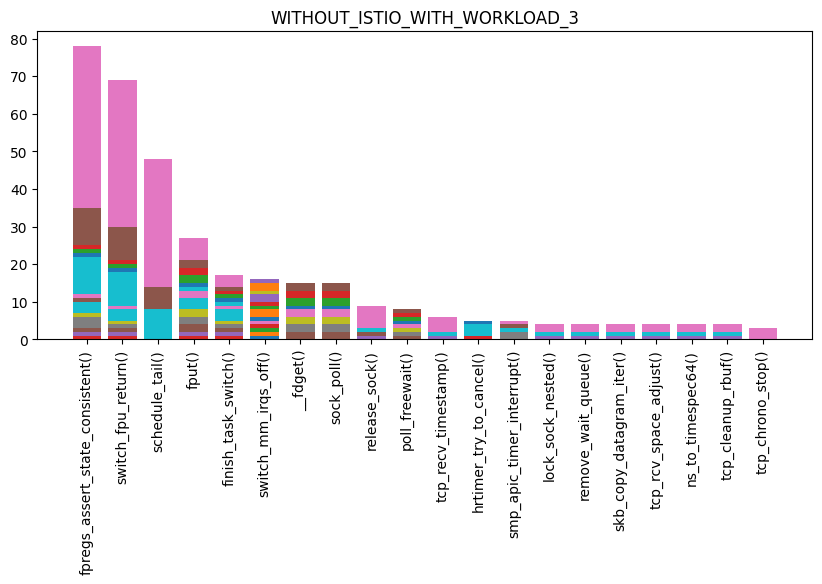

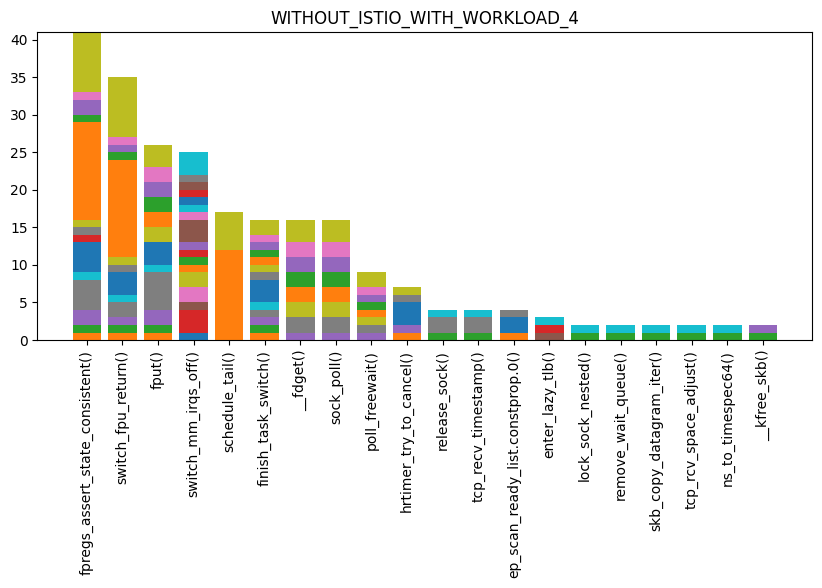

In [10]:
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

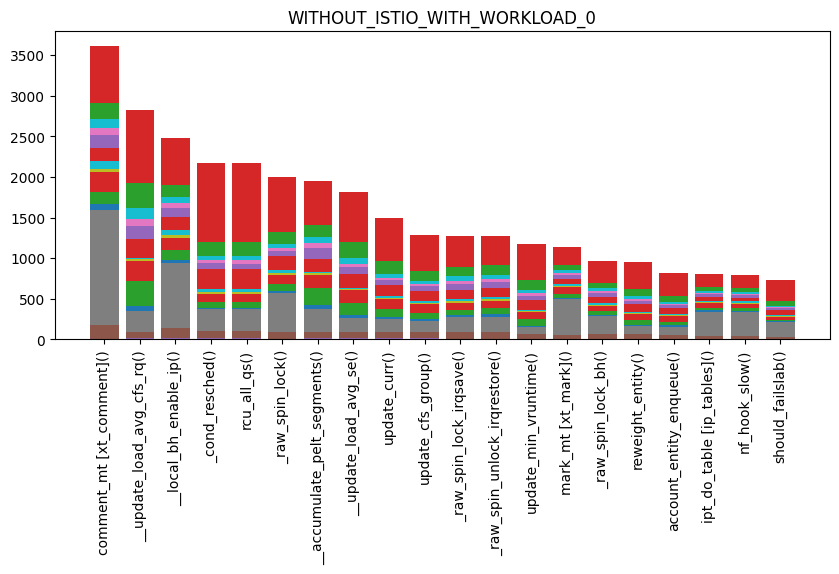

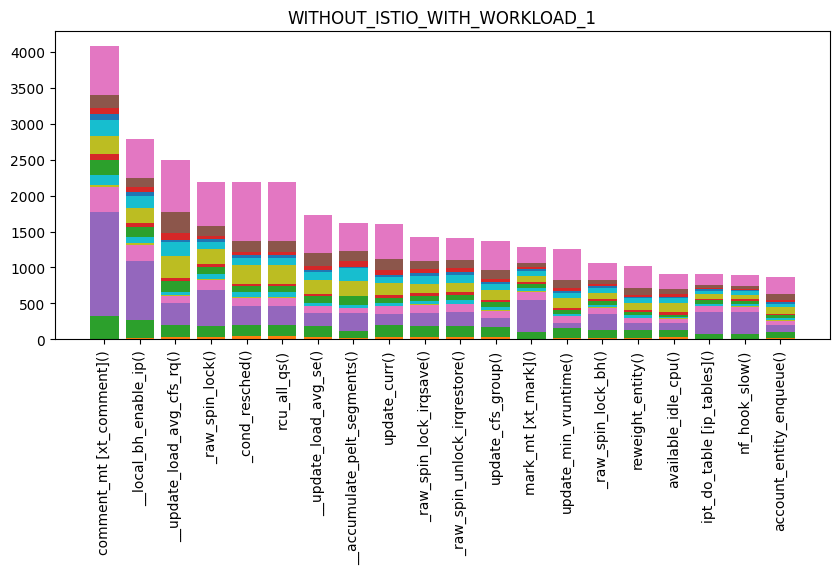

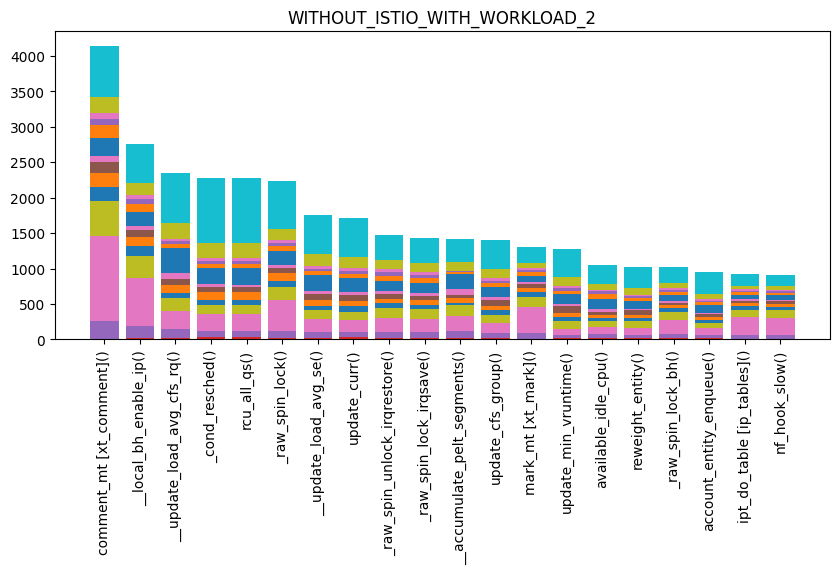

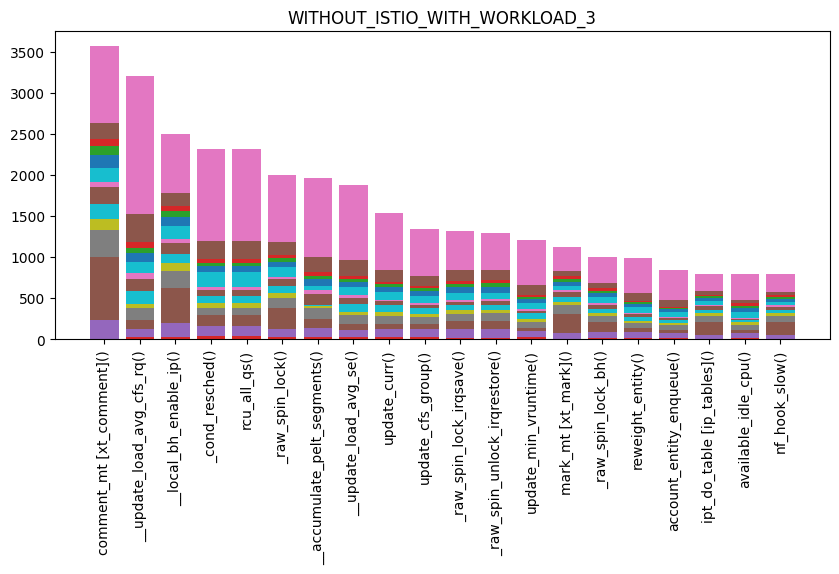

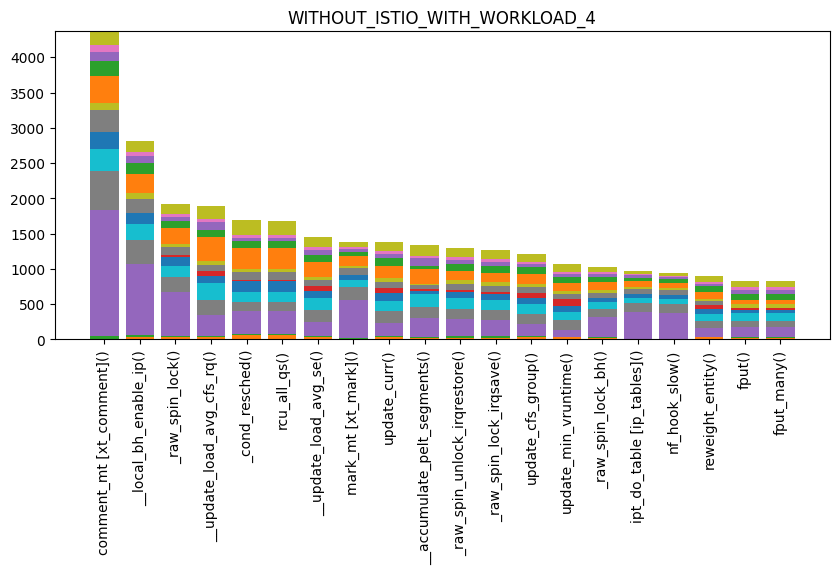

In [11]:
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i,recurse=True)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

In [9]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [10]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

1159 1252 1299


In [11]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'setup_object_debug.isra.0()', 'exit_rcu()', 'put_task_struct_rcu_user()', 'pids_release()', 'd_hash_and_lookup()', 'mem_cgroup_uncharge()', 'tcp_keepalive_timer()', 'detach_pid()', 'flush_sigqueue()', '__cpuset_node_allowed()', 'proc_exit_connector()', 'cgroup_release()', 'mod_node_page_state()', 'cleanup_timers()', '__page_cache_release()', 'new_slab()', 'get_random_u32()', 'free_pid()', 'exit_tasks_rcu_finish()', '__put_page()', 'pids_cancel.constprop.0()', 'mempolicy_slab_node()', '__change_pid()', 'full_name_hash()', 'add_device_randomness()', 'tcp_write_timer_handler()', 'tcp_write_timer()', 'allocate_slab()', 'posix_cpu_timers_exit()', 'd_lookup()', 'queue_work_on()', 'free_compound_page()', 'PageHuge()', 'put_task_stack()', 'kprobe_flush_task()', '__put_compound_page()', 'release_thread()', 'mpol_put_task_policy()', '__cleanup_sighand()', 'task_dead_fair()', 'vfree_atomic()'}

Calls in 0 but not in 2 
{'setup_object_debug.isra.0()', '__ip_make_skb()', 

In [12]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [13]:
diff_count = get_count_diff(function_counts=function_counts)

In [14]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('mempolicy_slab_node()', 100.0),
 ('__cpuset_node_allowed()', 100.0),
 ('new_slab()', 100.0),
 ('allocate_slab()', 100.0),
 ('mod_node_page_state()', 100.0),
 ('get_random_u32()', 100.0),
 ('setup_object_debug.isra.0()', 100.0),
 ('d_hash_and_lookup()', 100.0),
 ('full_name_hash()', 100.0),
 ('d_lookup()', 100.0),
 ('cgroup_release()', 100.0),
 ('pids_release()', 100.0),
 ('pids_cancel.constprop.0()', 100.0),
 ('posix_cpu_timers_exit()', 100.0),
 ('cleanup_timers()', 100.0),
 ('add_device_randomness()', 100.0),
 ('detach_pid()', 100.0),
 ('__change_pid()', 100.0),
 ('free_pid()', 100.0),
 ('flush_sigqueue()', 100.0),
 ('__cleanup_sighand()', 100.0),
 ('release_thread()', 100.0),
 ('put_task_struct_rcu_user()', 100.0),
 ('proc_exit_connector()', 100.0),
 ('mpol_put_task_policy()', 100.0),
 ('__put_page()', 100.0),
 ('__put_compound_page()', 100.0),
 ('PageHuge()', 100.0),
 ('__page_cache_release()', 100.0),
 ('free_compound_page()', 100.0),
 ('mem_cgroup_uncharge()', 100.0),
 ('exit_r

In [15]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('mempolicy_slab_node()', 100.0),
 ('__cpuset_node_allowed()', 100.0),
 ('new_slab()', 100.0),
 ('allocate_slab()', 100.0),
 ('mod_node_page_state()', 100.0),
 ('get_random_u32()', 100.0),
 ('setup_object_debug.isra.0()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('d_hash_and_lookup()', 100.0),
 ('full_name_hash()', 100.0),
 ('d_lookup()', 100.0),
 ('cgroup_release()', 100.0),
 ('pids_release()', 100.0),
 ('pids_cancel.constprop.0()', 100.0),
 ('posix_cpu_timers_exit()', 100.0),
 ('cleanup_timers()', 100.0),
 ('add_device_randomness()', 100.0),
 ('detach_pid()', 100.0),
 ('__change_pid()', 100.0),
 ('free_pid()', 100.0),
 ('flush_sigqueue()', 100.0),
 ('__cleanup_sighand()', 100.0),
 ('release_thread()', 100.0),
 ('put_task_struct_rcu_user()', 100.0),
 ('proc_exit_connector()', 100.0),
 ('mpol_put_task_policy()', 100.0),
 ('task_dead_fair()', 100.0),
 ('kprobe_flush_task()', 100.0),
 ('put_task_sta

In [16]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('nf_ct_delete [nf_conntrack]()', 100.0),
 ('nf_conntrack_eventmask_report [nf_conntrack]()', 100.0),
 ('nf_ct_delete_from_lists [nf_conntrack]()', 100.0),
 ('nf_ct_helper_destroy [nf_conntrack]()', 100.0),
 ('nf_ct_remove_expectations [nf_conntrack]()', 100.0),
 ('nf_ct_add_to_dying_list [nf_conntrack]()', 100.0),
 ('nf_conntrack_destroy()', 100.0),
 ('destroy_conntrack [nf_conntrack]()', 100.0),
 ('nf_conntrack_free [nf_conntrack]()', 100.0),
 ('nf_ct_ext_destroy [nf_conntrack]()', 100.0),
 ('nf_nat_cleanup_conntrack [nf_nat]()', 100.0),
 ('__nf_nat_cleanup_conntrack [nf_nat]()', 100.0),
 ('kfree_call_rcu()', 100.0),
 ('tcp_fastretrans_alert()', 100.0),
 ('tcp_identify_packet_loss()', 100.0),
 ('tcp_rack_mark_lost()', 100.0),
 ('tcp_rack_detect_loss()', 100.0),
 ('tcp_any_retrans_done.part.0()', 100.0),
 ('tcp_try_keep_open()', 100.0),
 ('process_timeout()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('file_free_rcu()', 100.0),
 ('_

In [17]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('process_timeout()', 100.0),
 ('do_IRQ()', 100.0),
 ('handle_edge_irq()', 100.0),
 ('irq_may_run()', 100.0),
 ('irq_chip_ack_parent()', 100.0),
 ('apic_ack_edge()', 100.0),
 ('apic_chip_data.part.0()', 100.0),
 ('__irq_complete_move()', 100.0),
 ('apic_ack_irq()', 100.0),
 ('handle_irq_event()', 100.0),
 ('handle_irq_event_percpu()', 100.0),
 ('__handle_irq_event_percpu()', 100.0),
 ('vring_interrupt()', 100.0),
 ('virtblk_done [virtio_blk]()', 100.0),
 ('virtqueue_disable_cb()', 100.0),
 ('virtqueue_get_buf()', 100.0),
 ('virtqueue_get_buf_ctx()', 100.0),
 ('detach_buf_split()', 100.0),
 ('blk_mq_complete_request()', 100.0),
 ('blk_mq_end_request()', 100.0),
 ('blk_update_request()', 100.0),
 ('blk_stat_add()', 100.0),
 ('wbt_data_dir()', 100.0),
 ('blk_account_io_done()', 100.0),
 ('__rq_qos_done()', 100.0),
 ('wbt_done()', 100.0),
 ('flush_end_io()', 100.0),
 ('blk_flush_complete_seq()', 100.0),
 ('blk_account_io_completion()', 100.0),
 ('bio_advance()', 100.0),
 ('bio_endio()', 1

In [18]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('do_IRQ()', 100.0),
 ('handle_edge_irq()', 100.0),
 ('irq_may_run()', 100.0),
 ('irq_chip_ack_parent()', 100.0),
 ('apic_ack_edge()', 100.0),
 ('apic_chip_data.part.0()', 100.0),
 ('__irq_complete_move()', 100.0),
 ('apic_ack_irq()', 100.0),
 ('handle_irq_event()', 100.0),
 ('handle_irq_event_percpu()', 100.0),
 ('__handle_irq_event_percpu()', 100.0),
 ('vring_interrupt()', 100.0),
 ('virtblk_done [virtio_blk]()', 100.0),
 ('virtqueue_disable_cb()', 100.0),
 ('virtqueue_get_buf()', 100.0),
 ('virtqueue_get_buf_ctx()', 100.0),
 ('detach_buf_split()', 100.0),
 ('blk_mq_complete_request()', 100.0),
 ('blk_mq_end_request()', 100.0),
 ('blk_update_request()', 100.0),
 ('blk_stat_add()', 100.0),
 ('wbt_data_dir()', 100.0),
 ('blk_account_io_done()', 100.0),
 ('__rq_qos_done()', 100.0),
 ('wbt_done()', 100.0),
 ('flush_end_io()', 100.0),
 ('blk_flush_complete_seq()', 100.0),
 ('blk_account_io_completion()', 100.0),
 ('bio_advance()', 100.0),
 ('bio_endio()', 100.0),
 ('__rq_qos_done_bio()',

In [19]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('account_user_time()', 100.0),
 ('queued_write_lock_slowpath()', 100.0),
 ('tcp_v4_send_reset()', 100.0),
 ('ip_send_unicast_reply()', 100.0),
 ('__ip_options_echo()', 100.0),
 ('dev_get_by_index_rcu()', 100.0),
 ('security_skb_classify_flow()', 100.0),
 ('ip_append_data.part.0()', 100.0),
 ('ip_setup_cork()', 100.0),
 ('__ip_append_data.isra.0()', 100.0),
 ('skb_put()', 100.0),
 ('ip_reply_glue_bits()', 100.0),
 ('csum_partial_copy_nocheck()', 100.0),
 ('ip_push_pending_frames()', 100.0),
 ('__ip_make_skb()', 100.0),
 ('ip_send_skb()', 100.0),
 ('ipv4_conntrack_local [nf_conntrack]()', 100.0),
 ('nf_nat_ipv4_local_fn [nf_nat]()', 100.0),
 ('ip_route_me_harder()', 100.0),
 ('inet_addr_type_dev_table()', 100.0),
 ('l3mdev_fib_table_rcu()', 100.0),
 ('sock_wfree()', 100.0),
 ('__skb_checksum_complete()', 100.0),
 ('__skb_checksum()', 100.0),
 ('csum_partial()', 100.0),
 ('do_csum()', 100.0),
 ('eventpoll_release_file()', 100.0),
 ('ep_remove()', 100.0),
 ('ep_unregister_pollwait.isra.0

In [15]:
def get_process_latency(run, run_no, blacklist=FUNC_BLACKLIST):
    latency = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    print(blacklist)

    def update_latency(function,pid):
        
        # for call in data:
        func_name = function['function_name']
        if func_name not in blacklist:   
            latency[func_name] = latency.get(func_name, {})        
            latency[func_name][pid] = latency.get(func_name).get(pid,0) + function['time']
            for child in function['children']:
                    latency[func_name][pid] -= child['time']
        for child in function["children"]:
                update_latency(child,pid)

    
    for pid in run:
        for function in run[pid]:
            update_latency(function,pid)
    for function,data in latency.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + latency[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + latency[function][pid]
        if(len(process_count[function])==0):
            del process_count[function]
                

    return process_count

In [21]:
runs = get_runs()

{'BLANK', 'do_syscall_64()'}
{'BLANK', 'do_syscall_64()'}
{'BLANK', 'do_syscall_64()'}
{'BLANK', 'do_syscall_64()'}
{'BLANK', 'do_syscall_64()'}


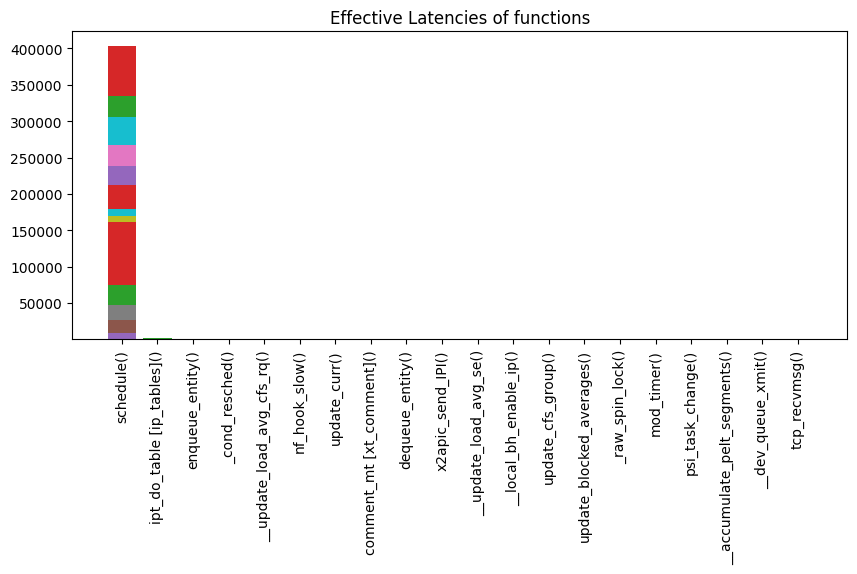

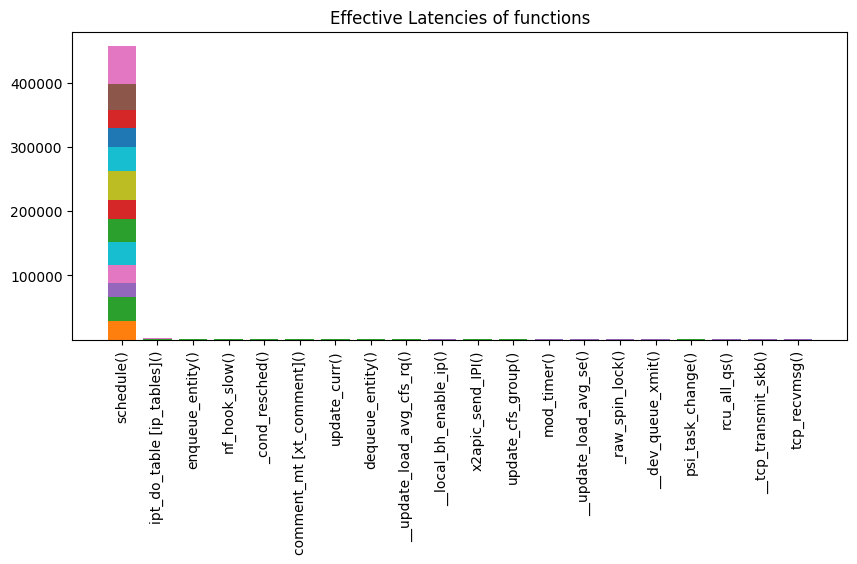

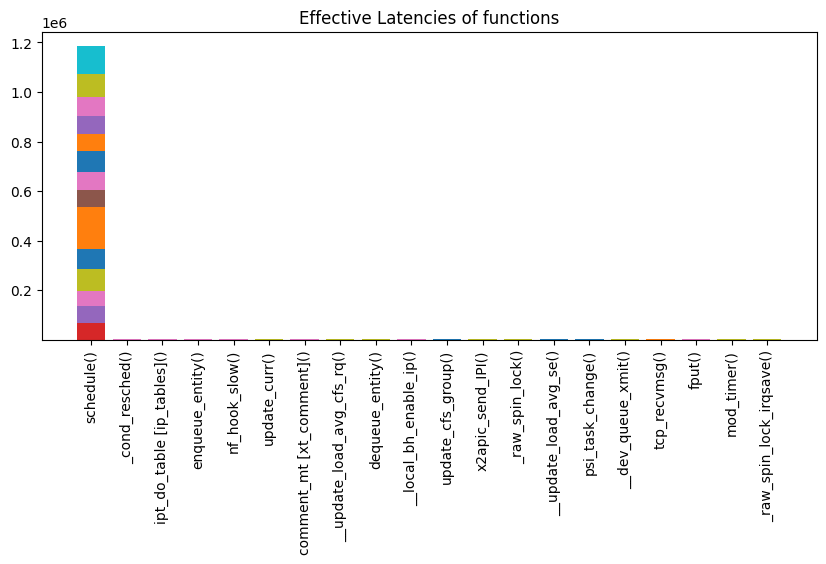

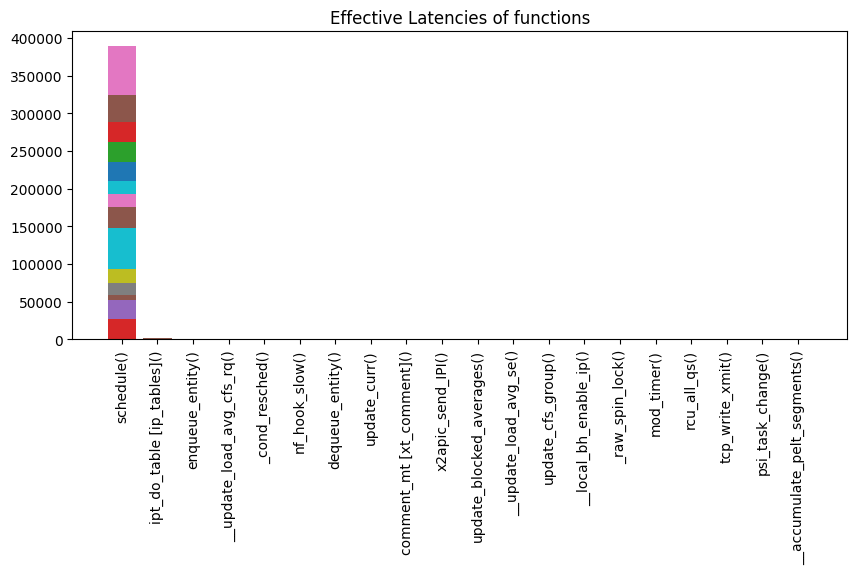

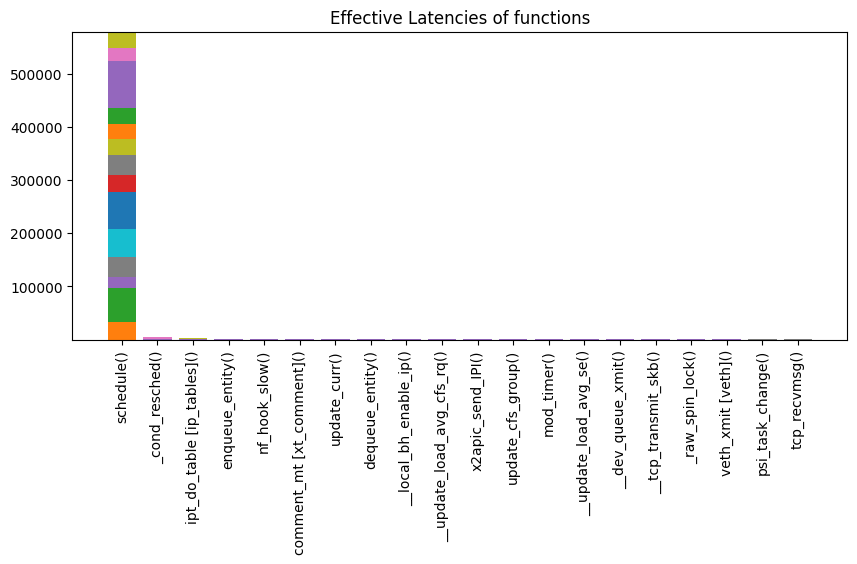

In [13]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_process_latency(runs[i],i))

for latency in latencies:
    plot_stacked_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

**The schedule() functions:**<br/>
It is a kernel function which is responsible for running the linux scheduler. It is called whenever there is an interrupt and it handles the process of switching threads. waking up threads, etc

It is the most time consuming function in the 01 workload and takes 2-2.5s of time overall which is 60s

{'BLANK', 'do_syscall_64()', 'schedule()'}
{'BLANK', 'do_syscall_64()', 'schedule()'}
{'BLANK', 'do_syscall_64()', 'schedule()'}
{'BLANK', 'do_syscall_64()', 'schedule()'}
{'BLANK', 'do_syscall_64()', 'schedule()'}


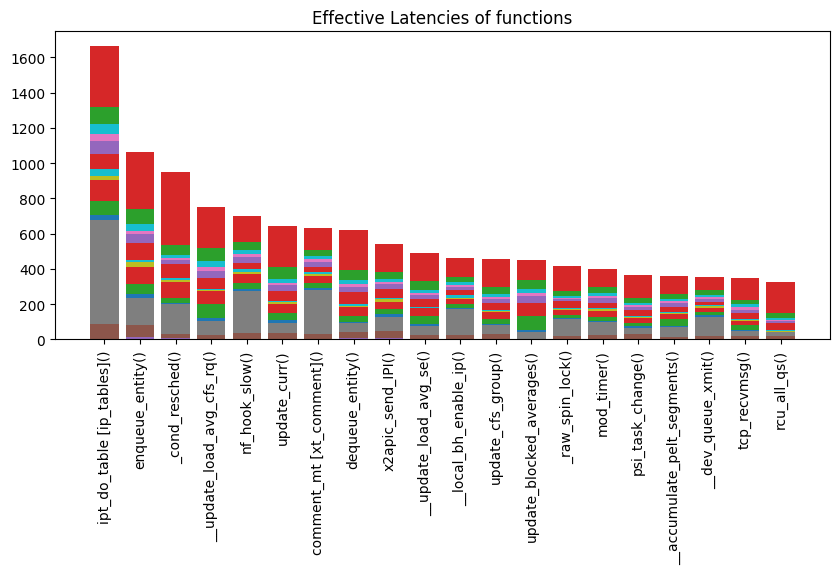

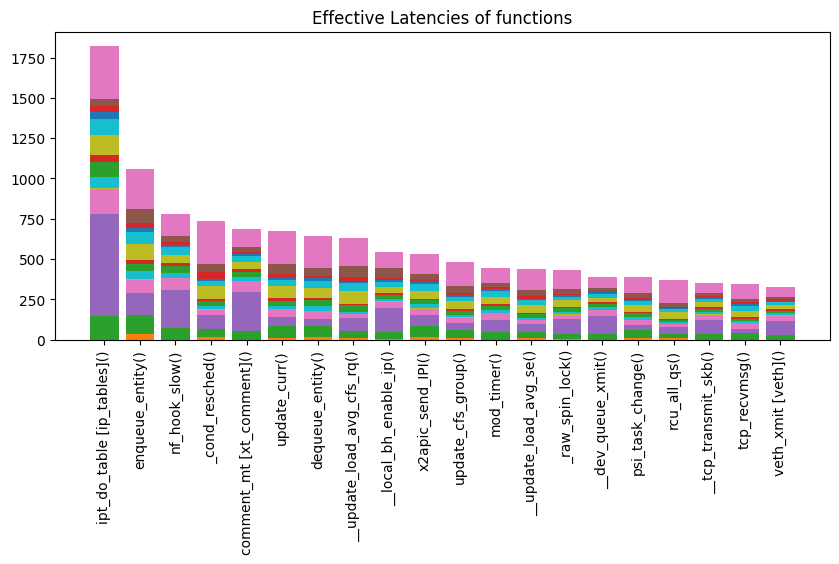

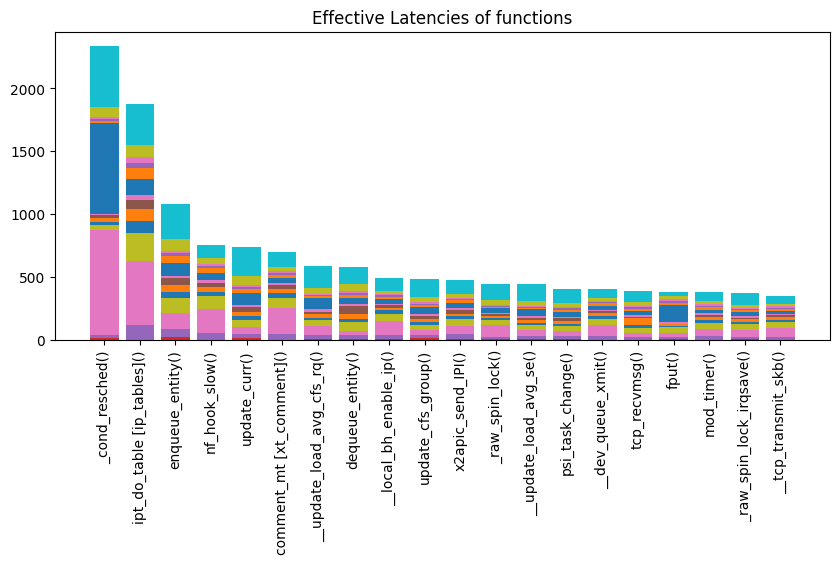

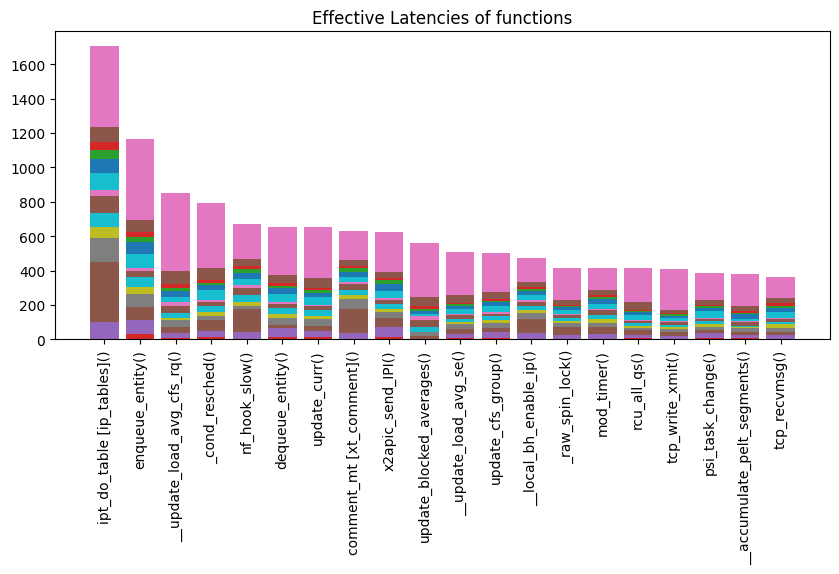

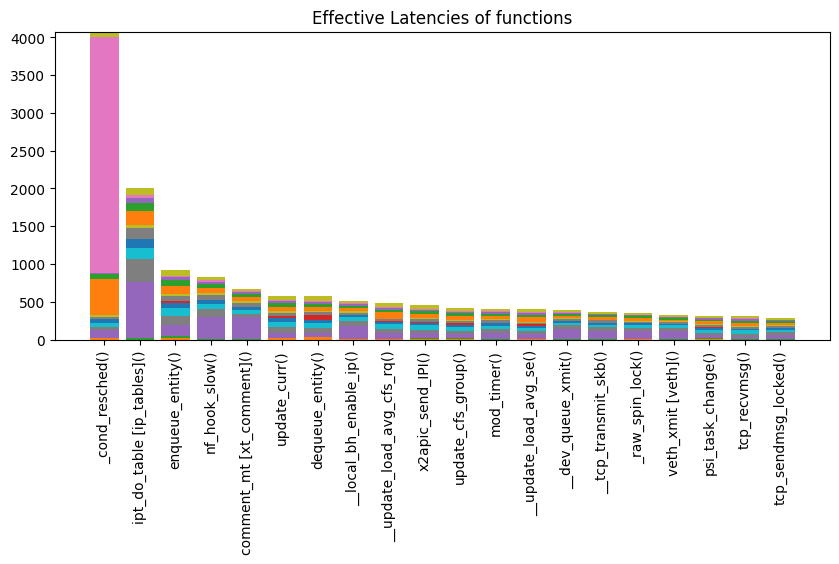

In [14]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_process_latency(runs[i], i, FUNC_BLACKLIST.union({"schedule()"})))

for latency in latencies:
    plot_stacked_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

In [25]:
def get_latency_by_pid(run,function=None):
    latency = {}
    
    def update_latency(pid,data):
        
        for call in data:
            function_name = call['function_name']
            if not function or function_name == function:              
                latency[pid] = latency.get(pid, 0) + call['time']
                
                for child in call['children']:
                    latency[pid] -= child['time']

            update_latency(pid,call['children'])
    
    for pid,data in run.items():
        update_latency(pid,data)

    return latency

In [26]:
cnt=[]
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i],'ipt_do_table [ip_tables]()'))
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
        else:
            cnt.append(pid)
    print(count)

{'UserMentionServ': 590.8630000000007, 'HomeTimelineSer': 75.28499999999995, 'redis-server': 119.09800000000004, 'SocialGraphServ': 85.66399999999987, 'ComposePostServ': 347.2110000000001, 'UniqueIdService': 54.611999999999995, 'UrlShortenServi': 95.936, 'UserTimelineSer': 31.862999999999957, 'PostStorageServ': 74.74499999999993, 'MediaService': 41.10500000000002, 'TextService': 82.95199999999997, 'UserService': 23.518000000000008, 'openresty': 41.43000000000003}
{'ComposePostServ': 329.84299999999996, 'TextService': 122.902, 'UrlShortenServi': 39.53699999999998, 'UserMentionServ': 631.6010000000075, 'PostStorageServ': 101.44500000000015, 'HomeTimelineSer': 8.755000000000003, 'SocialGraphServ': 145.17400000000055, 'openresty': 98.52200000000012, 'UserService': 42.20000000000002, 'UniqueIdService': 41.57800000000001, 'MediaService': 38.688000000000045, 'UserTimelineSer': 157.1190000000005, 'redis-server': 63.04399999999998}
{'openresty': 72.10500000000019, 'TextService': 126.20899999999

In [27]:
cnt=[]
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i],'_cond_resched()'))
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
        else:
            cnt.append(pid)
    print(count)

{'ComposePostServ': 415.22700000000043, 'UserMentionServ': 169.56600000000054, 'HomeTimelineSer': 24.423999999999978, 'redis-server': 95.07799999999995, 'SocialGraphServ': 26.114999999999984, 'UniqueIdService': 16.735999999999994, 'UrlShortenServi': 55.237999999999985, 'UserTimelineSer': 6.021999999999999, 'PostStorageServ': 21.57699999999999, 'MediaService': 12.926000000000002, 'TextService': 81.14399999999996, 'UserService': 6.794999999999999, 'memcached': 7.308999999999996, 'openresty': 12.712000000000007}
{'ComposePostServ': 269.82899999999995, 'TextService': 80.27800000000002, 'UrlShortenServi': 48.263999999999996, 'UserMentionServ': 88.34300000000002, 'PostStorageServ': 31.16999999999996, 'HomeTimelineSer': 3.058, 'SocialGraphServ': 48.32399999999992, 'openresty': 25.607999999999986, 'UserService': 13.234000000000002, 'UniqueIdService': 44.36699999999999, 'MediaService': 12.331000000000005, 'memcached': 14.646000000000006, 'UserTimelineSer': 34.29699999999998, 'redis-server': 21.

In [28]:
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i],'ep_poll()'))
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
        else:
            print(pid)
    print(count)


{'redis-server': 15.30199999999827, 'memcached': 1.7940000000006844, 'openresty': 3.036999999999825}
{'openresty': 12.146999999998101, 'memcached': 4.925000000003726, 'redis-server': 6.39100000000243}
{'openresty': 16.31000000000615, 'redis-server': 22.27999999999133, 'memcached': 3.224999999994994}
{'redis-server': 11.217000000002692, 'memcached': 5.657999999998909, 'openresty': 6.652999999999596}
{'redis-server': 18.342999999998646, 'openresty': 11.919999999998822, 'kube-controller': 24.963999999995544, 'memcached': 6.645000000002285}


* ep_poll() a function that contributed to the most latency without workload has very low latency when the workload is given
* ipt_do_table [ip_tables]() is the function with most latency during a workload, contributed by the Services, mostly by User mention service and Compose post. ##todo find what function does
* _cond_resched() is another function with most latency, with the services contributing the most being Compose post, User mention and text services. Code that is known to be prone to long loops will, on occasion, call cond_resched() to give the scheduler a chance to run a higher-priority process.

In [29]:
def plot_piechart(counts,title):
    count=counts.copy()
    todel=[]
    def percent(pct):
        if pct>0.5:
            return "{:1.3f}%".format(pct)
        else:
            return ""
    count['others']=0
    for p,latency in count.items():
        percentage_latency=(latency/sum(count.values()))*100
        if percentage_latency<1 and p!='others':
            count['others']=count.get('others',0)+latency
            todel.append(p)
    for i in todel:
        count.pop(i)
    # print(title)
    plt.figure(figsize=(6, 4))
    plt.pie(count.values(),labels=count.keys(),autopct=percent,radius=2,center=(0,2))
    plt.title(title,pad=100)
    plt.show()

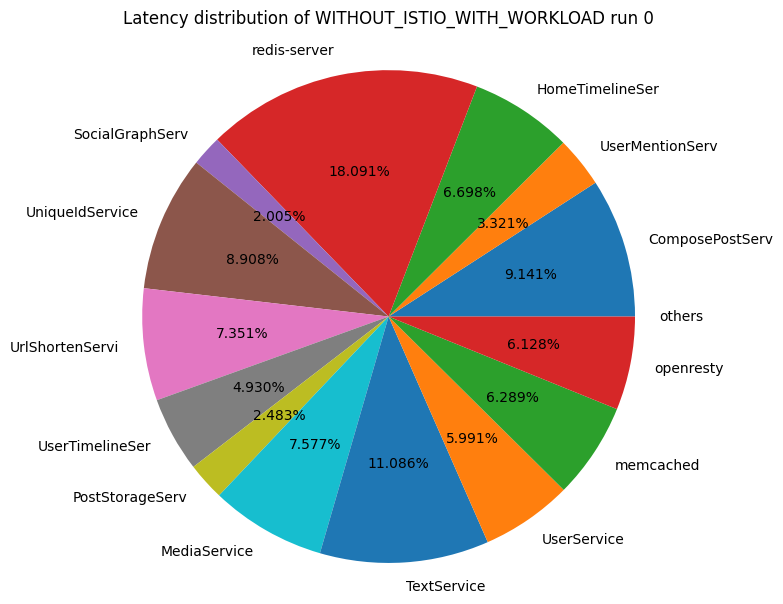

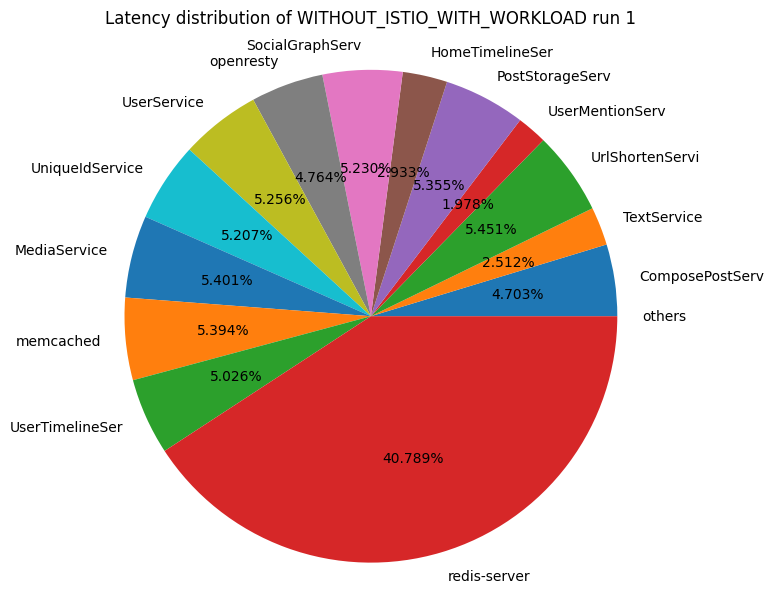

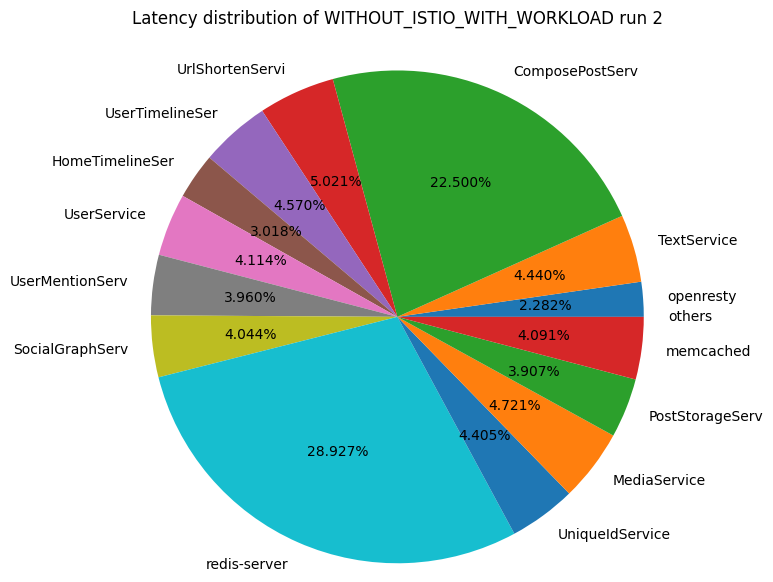

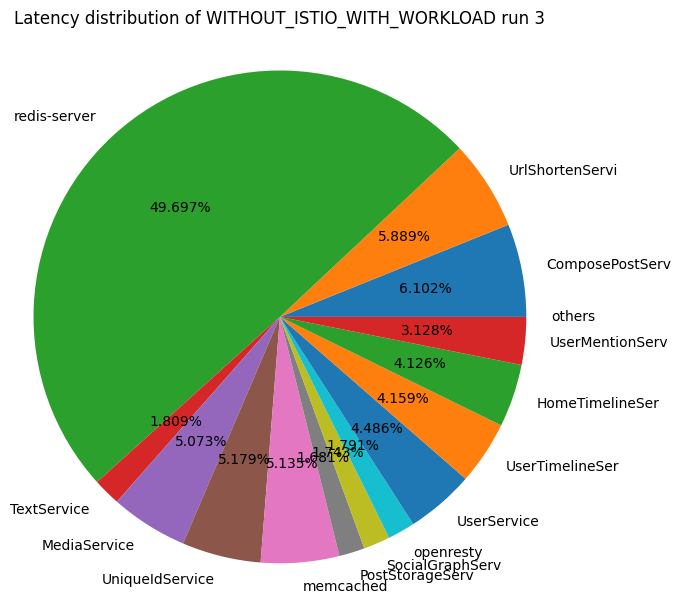

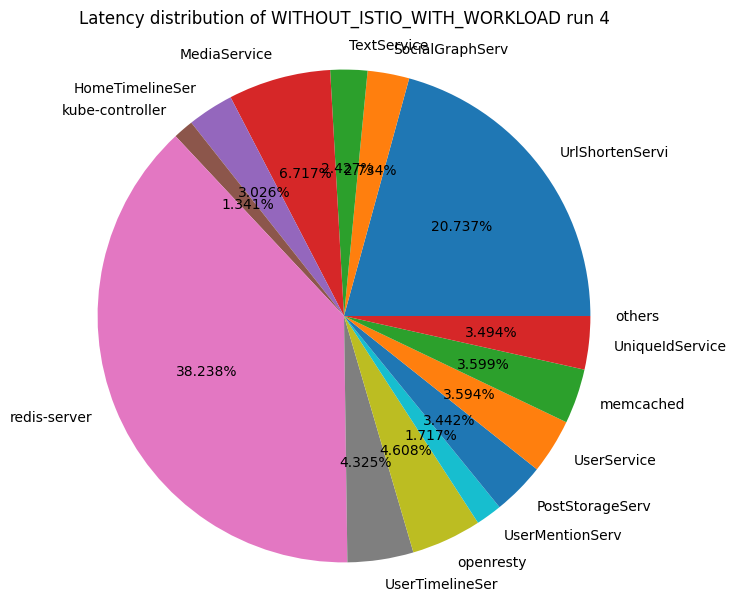

In [30]:
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i]))
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
    plot_piechart(count,f"Latency distribution of {WORKLOAD} run {i}")